# Predição de queimadas - Series temporais

Dataset utilizado: https://www.kaggle.com/datasets/mayaravalliero/fire-watch-brazil-2024?resource=download

## Instalação das bibliotecas

In [ ]:
!pip install prophet
!pip install pandas
!pip install matplotlib

In [ ]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


## Carregamento do dataset

In [ ]:
df = pd.read_csv('data.csv')
df['data'] = pd.to_datetime(df['data'])

df_prophet = df[['data', 'avg_risco_fogo']].rename(columns={'data': 'ds', 'avg_risco_fogo': 'y'})
df_prophet.head()

,ds,y
0,2024-01-01,0.0
1,2024-01-01,0.0
2,2024-01-01,0.0
3,2024-01-01,0.0
4,2024-01-01,0.0


In [ ]:
train_size = int(len(df_prophet) * 0.8)
train = df_prophet[:train_size]
test = df_prophet[train_size:]

## Previsão Prophet  
Prophet é uma ferramenta de forecasting (previsão) de séries temporais. Foi projetada para facilitar a criação de modelos de previsão precisos e interpretáveis. O Prophet é particularmente eficaz para dados que apresentam componentes sazonais fortes e tendências claras.

In [ ]:
model = Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpopuj7r7k/l94sk3sl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpopuj7r7k/jo653z1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11716', 'data', 'file=/tmp/tmpopuj7r7k/l94sk3sl.json', 'init=/tmp/tmpopuj7r7k/jo653z1g.json', 'output', 'file=/tmp/tmpopuj7r7k/prophet_modelddmib3xf/prophet_model-20241003154028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:40:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


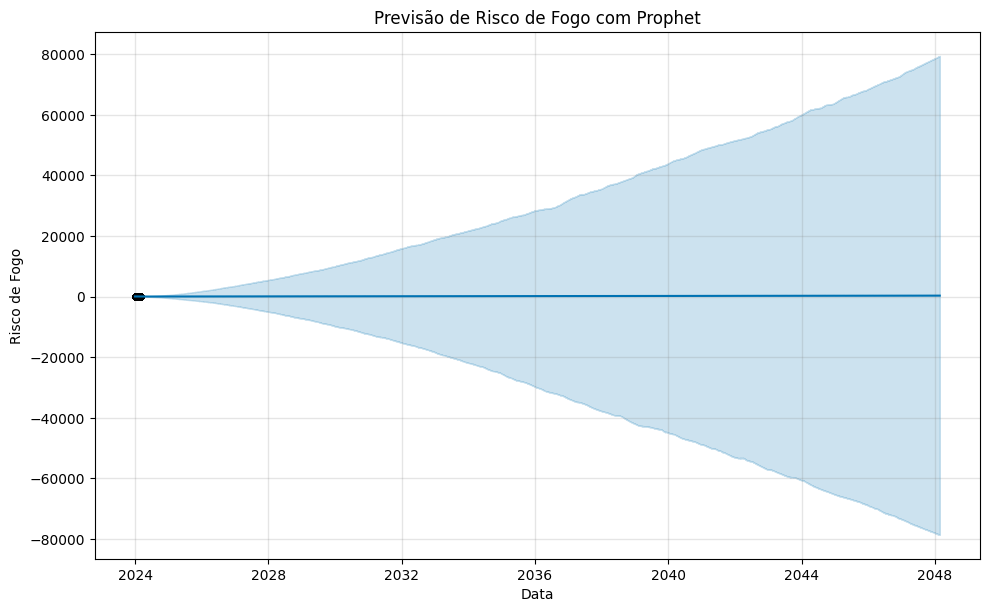

In [ ]:
model.plot(forecast)
plt.title('Previsão de Risco de Fogo com Prophet')
plt.xlabel('Data')
plt.ylabel('Risco de Fogo')
plt.show()


## LSTM

In [ ]:
# Carregar o conjunto de dados
df_lstm = pd.read_csv('/content/data.csv')

# Selecionar a coluna de data e a variável alvo
df_lstm = df_lstm[['data', 'avg_risco_fogo']]

# Converter a coluna de data para o formato datetime
df_lstm['data'] = pd.to_datetime(df_lstm['data'])
df_lstm.set_index('data', inplace=True)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

# Função para criar a estrutura de dados para LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir em treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


## Construção e Treinamento do Modelo LSTM:

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0812 - val_loss: 0.0763
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.0758 - val_loss: 0.0750
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0751 - val_loss: 0.0761
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0763 - val_loss: 0.0761
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0751 - val_loss: 0.0761
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0765 - val_loss: 0.0758
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0758 - val_loss: 0.0813
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0755 - val_loss: 0.0773
Epoch 9/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0753 - val_loss: 0.0752
Epoch 10/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0745 - val_loss: 0.0760
Epoch 11/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0761 - val_loss: 0.0751
Epoch 12

In [ ]:
# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverter a normalização
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


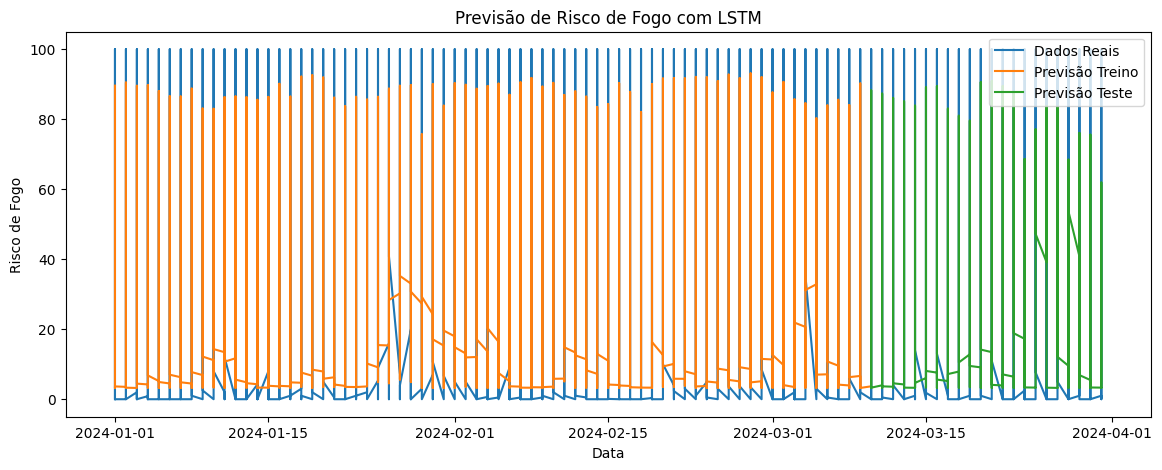

In [ ]:
# Plotar as previsões
plt.figure(figsize=(14,5))
plt.plot(df_lstm.index, df_lstm['avg_risco_fogo'], label='Dados Reais')
plt.plot(df_lstm.index[time_step:train_size+time_step], train_predict, label='Previsão Treino')
plt.plot(df_lstm.index[train_size+time_step+1:], test_predict, label='Previsão Teste')
plt.xlabel('Data')
plt.ylabel('Risco de Fogo')
plt.title('Previsão de Risco de Fogo com LSTM')
plt.legend()
plt.show()

## Cálculo de Métricas de Erro

O MAE é uma métrica amplamente utilizada para problemas de regressão porque fornece uma interpretação direta do erro médio em unidades originais da variável alvo. O MAE é menos sensível a outliers em comparação com o Mean Squared Error (MSE), tornando-o uma escolha adequada quando todos os erros têm a mesma importância.

**Desempenho Superior do LSTM:**

- O MAE do LSTM é significativamente menor que o do Prophet, indicando que o modelo LSTM está fazendo previsões mais precisas em média.
- O LSTM capturou melhor as dependências temporais e padrões nos dados, possivelmente devido à sua capacidade de modelar relações de longo prazo e não-linearidades.

fonte: https://revistas.fucamp.edu.br/index.php/getec/article/view/2895/1834#:~:text=O%20MAE%20%C3%A9%20uma%20medida,tende%20a%20penalizar%20mais%20previs%C3%B5es

In [ ]:
prophet_predictions = forecast['yhat'][-len(test):]
mae_prophet = mean_absolute_error(test['y'], prophet_predictions)
print(f'MAE do Prophet: {mae_prophet}')

mae_lstm = mean_absolute_error(y_test_actual[0], test_predict.flatten())
print(f'MAE do LSTM: {mae_lstm}')

MAE do Prophet: 145.22535315991468
MAE do LSTM: 19.74243405107853
